notebook for error analyse

In [1]:
import logging
import sys

import matplotlib.pyplot as plt

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import sys

sys.path.append('../scripts')
sys.path.append('../')
from scripts import centroids_graph_builder
from multiprocessing import Pool
from scripts import dijkstra
import numpy as np
from tqdm.notebook import trange
from scripts import graph_osm_loader, utils

import networkx as nx
from scripts import clustering

In [3]:
NUM_ITERATION = 2
WORKER = 10  # количество потоков

In [4]:
    # 'PARIS': 'R71525',
    # 'Prague': 'R435514',
    # 
    # 'DUBAI': 'R3766483',


In [13]:
GRAPH_ID = 'R71525'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # зарузка графа
N = 10000
p = 3 / N
# g = get_rand_graph(N,p)
# g = get_graph()
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

9507 14804


In [14]:
@utils.profile(iterations=2)
def work():
    return nx.connectivity.stoer_wagner(g, weight='length')[1] 

In [15]:
work()

(131.62689352035522,
 ([5057169769],
  [5509971973,
   166297606,
   271450120,
   116129800,
   116129802,
   174981131,
   5509971981,
   268140568,
   141557799,
   209158195,
   6180929592,
   6171131962,
   6194954302,
   7228489799,
   1854603337,
   245399630,
   94175315,
   5383094356,
   5383094362,
   25002088,
   21659758,
   21659759,
   21659772,
   21659773,
   25198716,
   4964974719,
   203325570,
   677773445,
   430637190,
   256409741,
   906068109,
   258048145,
   21659803,
   21659818,
   21659819,
   21659820,
   21659821,
   258408623,
   21659826,
   21659827,
   5059182770,
   5059182773,
   5059182771,
   408749290,
   5059182779,
   63111356,
   249168058,
   5059182780,
   884211905,
   258048194,
   5059182789,
   267583686,
   12048793812,
   359071960,
   359071964,
   21659876,
   96141540,
   8894513383,
   175014120,
   256409832,
   169279721,
   252969207,
   175046904,
   244580618,
   9384198410,
   6200688912,
   94208275,
   178880787,
   25840

In [64]:
g.remove_edges_from(nx.selfloop_edges(g))

In [65]:
nodes = g.nodes()

In [66]:
path = utils.get_path('pouits', f'points_{GRAPH_ID}.pickle')
import os
import pickle
if os.path.exists(path):
    with open(path, 'rb') as fp:
        points = pickle.load(fp)
        fp.close()
else:
    points = [utils.get_node_for_initial_graph_v2(g) for _ in trange(100, desc='generate points')]
    with open(path, 'wb') as fp:
        pickle.dump(points, fp)
        fp.close()

In [67]:
# find path between two points
def find_path_length_h(
        g0: nx.Graph,
        g1: nx.Graph,
        cms: list[set[int]] | tuple[set[int]],
        from_node: int,
        to_node: int) -> float:
    from_cluster = g0.nodes()[from_node]['cluster']
    to_cluster = g0.nodes()[to_node]['cluster']
    
    path = dijkstra.dijkstra_pfa(g1, from_cluster, to_cluster)[1]
    cls = set([u for u in path])
    g = centroids_graph_builder.extract_cluster_list_subgraph(g0, cls, cms)
    return dijkstra.dijkstra_pfa(g, from_node, to_node, cms=cls)
    

In [68]:
@utils.profile(iterations=NUM_ITERATION)
def usual_path(g, p1, p2):
    return dijkstra.dijkstra_pfa(g, p1,p2)

@utils.profile(iterations=NUM_ITERATION)
def h_path(g, g1, cms, p1, p2):
    return find_path_length_h(g,g1, cms, p1, p2)

In [69]:
def do_calc(data_partitions):
    g, g1, cms, point_partition, worker_number = data_partitions

    stat = {
        'l': [],
        'h_l': [],
        'p': [],
        'h_p': [],
        'time_l': [],
        'time_h': [],
        'delta': []
    }

    
    for p1, p2 in point_partition:
        # класический дейкстра
        time_l, (l, p) = usual_path(g, p1, p2)
        # иерархический
        time_h, (h_l, h_p) = h_path(g, g1, cms, p1, p2)
        delta = (h_l - l) / l * 100

        stat['l'].append(l)  # длина обычного пути
        stat['h_l'].append(h_l)  # длина иерархического пути
        stat['p'].append(p)  # обычный путь
        stat['h_p'].append(h_p)  # иерархический путь
        stat['delta'].append(delta)  # разница в длине
        stat['time_l'].append(time_l)  # обычное время 
        stat['time_h'].append(time_h)  # иерархическое
    return stat


In [70]:
def get_error(g, cms):
    cls2n =  centroids_graph_builder.get_cls2n(g) # мапа кластер к соседним кластерам 
    g1, cls2c = centroids_graph_builder.build_center_graph(g, cms, cls2n, log=False)   
    
    data = [(g, g1, cms, [p for p in points[i::WORKER]], i) for i in range(WORKER)]
    with Pool(WORKER) as p:
        stat = {k: v for r in p.imap_unordered(do_calc, data) for k, v in r.items()}
    d, a =  np.mean(stat['delta']),np.mean(np.array(stat['time_l']) / np.array(stat['time_h']))
    
    return cms, centroids_graph_builder.get_cls2hubs(g), d, a 

In [71]:
data = {
    'q' : [],
    'e': [],
    'a':[],
    'n':[],
    'n_mean':[]
}

In [14]:
for r in trange(1,1000,10):
    r = r / 10
    cms, cls2hubs, d, a = get_error(g, r) 
    q = nx.community.partition_quality(g, cms)
    data['q'].append(q)
    data['e'].append(d)
    data['a'].append(a)
    data['n'].append(len(set(h for s in cls2hubs.values() for h in s)))
    data['n_mean'].append(np.mean([len(s) for s in cls2hubs.values()]))

  0%|          | 0/100 [00:00<?, ?it/s]

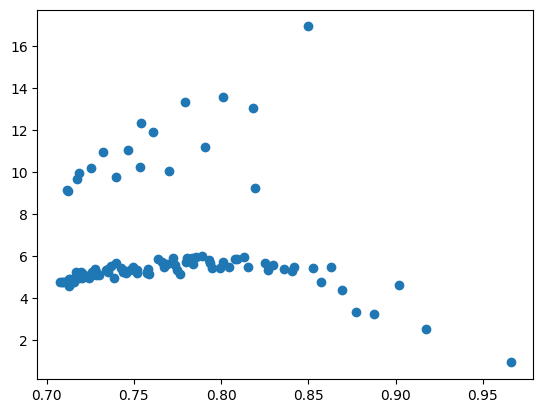

In [20]:
plt.scatter([x[0] for x in data['q']], data['a'])

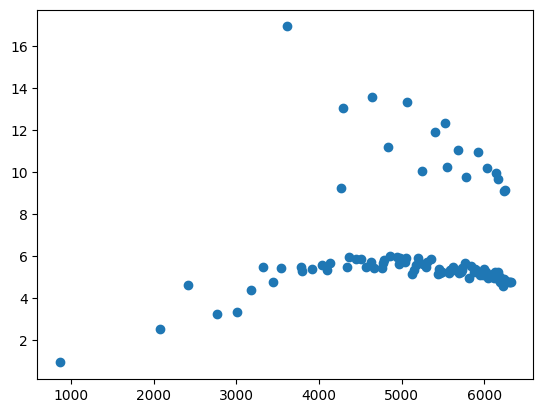

In [19]:
plt.scatter([x for x in data['n']], data['a'])

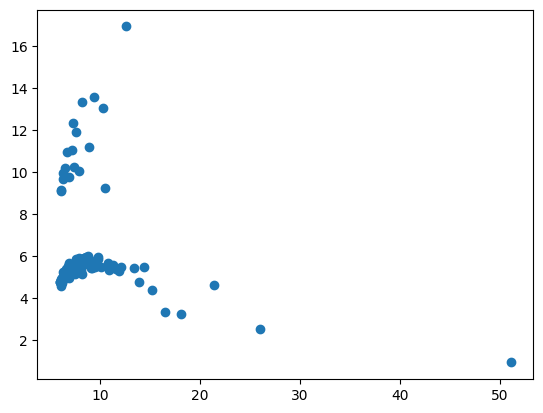

In [18]:
plt.scatter([x for x in data['n_mean']], data['a'])

In [91]:
def validate_cms(H: nx.Graph, communities: list[set[int]] | tuple[set[int]]) -> list[set[int]]:
    cls = []
    if not H.is_directed():
        for i, c in enumerate(communities):
            for n in nx.connected_components(H.subgraph(c)):
                cls.append(n)
    else:
        cls = communities
    for i, ids in enumerate(cls):
        for j in ids:
            H.nodes()[j]['cluster'] = i
    return cls


  0%|          | 0/9507 [00:00<?, ?it/s]

In [73]:
cms = clustering.resolve_louvain_communities(g, resolution=50.5)
cms, cls2hubs, d, a = get_error(g, cms) 
q = nx.community.partition_quality(g, cms)
print(f"""
q: {q}
acceleration: {a}
delta: {d}
""")


q: (0.7565522831667117, 0.9986627944714173)
acceleration: 4.64811285085823
delta: 19.85769835991699


In [93]:
cms = nx.community.girvan_newman(g)
cms = [v for v in cms]
print(cms)
validate_cms(g, cms)

cms, cls2hubs, d, a = get_error(g, cms) 
q = nx.community.partition_quality(g, cms)
print(f"""
q: {q}
acceleration: {a}
delta: {d}
""")

KeyboardInterrupt: 

In [75]:
cms = clustering.resolve_k_means_communities(g, resolution=50.5)
cms, cls2hubs, d, a = get_error(g, cms) 
q = nx.community.partition_quality(g, cms)
print(f"""
q: {q}
acceleration: {a}
delta: {d}
""")

2024-12-20 20:00:00,325 - root - INFO - communities: 742

q: (0.7472304782491218, 0.998620370550487)
acceleration: 4.270256758452598
delta: 5.681197737245389


KeyboardInterrupt: 